# Order Delivery Time Prediction

## Objectives
The objective of this assignment is to build a regression model that predicts the delivery time for orders placed through Porter. The model will use various features such as the items ordered, the restaurant location, the order protocol, and the availability of delivery partners.

The key goals are:
- Predict the delivery time for an order based on multiple input features
- Improve delivery time predictions to optimiae operational efficiency
- Understand the key factors influencing delivery time to enhance the model's accuracy

## Data Pipeline
The data pipeline for this assignment will involve the following steps:
1. **Data Loading**
2. **Data Preprocessing and Feature Engineering**
3. **Exploratory Data Analysis**
4. **Model Building**
5. **Model Inference**

## Data Understanding
The dataset contains information on orders placed through Porter, with the following columns:

| Field                     | Description                                                                                 |
|---------------------------|---------------------------------------------------------------------------------------------|
| market_id                 | Integer ID representing the market where the restaurant is located.                         |
| created_at                | Timestamp when the order was placed.                                                        |
| actual_delivery_time      | Timestamp when the order was delivered.                                                     |
| store_primary_category    | Category of the restaurant (e.g., fast food, dine-in).                                      |
| order_protocol            | Integer representing how the order was placed (e.g., via Porter, call to restaurant, etc.). |
| total_items               | Total number of items in the order.                                                         |
| subtotal                  | Final price of the order.                                                                   |
| num_distinct_items        | Number of distinct items in the order.                                                      |
| min_item_price            | Price of the cheapest item in the order.                                                    |
| max_item_price            | Price of the most expensive item in the order.                                              |
| total_onshift_dashers     | Number of delivery partners on duty when the order was placed.                              |
| total_busy_dashers        | Number of delivery partners already occupied with other orders.                             |
| total_outstanding_orders  | Number of orders pending fulfillment at the time of the order.                              |
| distance                  | Total distance from the restaurant to the customer.                                         |


## **Importing Necessary Libraries**

In [3]:
# Import essential libraries for data manipulation and analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm
import scipy.stats as stats




## **1. Loading the data**
Load 'porter_data_1.csv' as a DataFrame

In [4]:
# Importing the file porter_data_1.csv
import pandas as pd
df = pd.read_csv("/content/porter_data_1 (1).csv")
df.head(2)

,market_id,created_at,actual_delivery_time,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,distance
0,1.0,2015-02-06 22:24:17,2015-02-06 23:11:17,4,1.0,4,3441,4,557,1239,33.0,14.0,21.0,34.44
1,2.0,2015-02-10 21:49:25,2015-02-10 22:33:25,46,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,27.60


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175777 entries, 0 to 175776
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   market_id                 175777 non-null  float64
 1   created_at                175777 non-null  object 
 2   actual_delivery_time      175777 non-null  object 
 3   store_primary_category    175777 non-null  int64  
 4   order_protocol            175777 non-null  float64
 5   total_items               175777 non-null  int64  
 6   subtotal                  175777 non-null  int64  
 7   num_distinct_items        175777 non-null  int64  
 8   min_item_price            175777 non-null  int64  
 9   max_item_price            175777 non-null  int64  
 10  total_onshift_dashers     175777 non-null  float64
 11  total_busy_dashers        175777 non-null  float64
 12  total_outstanding_orders  175777 non-null  float64
 13  distance                  175777 non-null  f

## **2. Data Preprocessing and Feature Engineering** <font color = red>[15 marks]</font> <br>

#### **2.1 Fixing the Datatypes**  <font color = red>[5 marks]</font> <br>
The current timestamps are in object format and need conversion to datetime format for easier handling and intended functionality

##### **2.1.1** <font color = red>[2 marks]</font> <br>
Convert date and time fields to appropriate data type

In [6]:
# Convert 'created_at' and 'actual_delivery_time' columns to datetime format
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])
print("Data types after datetime conversion:")
print(df[['created_at', 'actual_delivery_time']].dtypes)
print("\n")

Data types after datetime conversion:
created_at              datetime64[ns]
actual_delivery_time    datetime64[ns]
dtype: object




##### **2.1.2**  <font color = red>[3 marks]</font> <br>
Convert categorical fields to appropriate data type

In [7]:
# Convert categorical features to category type
df['store_primary_category'] = df['store_primary_category'].astype('category')
df['order_protocol'] = df['order_protocol'].astype('category')

print("Data types after categorical conversion:")
print(df[['store_primary_category', 'order_protocol']].dtypes)


Data types after categorical conversion:
store_primary_category    category
order_protocol            category
dtype: object


#### **2.2 Feature Engineering** <font color = red>[5 marks]</font> <br>
Calculate the time taken to execute the delivery as well as extract the hour and day at which the order was placed

##### **2.2.1** <font color = red>[2 marks]</font> <br>
Calculate the time taken using the features `actual_delivery_time` and `created_at`

In [8]:
# Calculate time taken in minutes
df["time_taken"] = (df["actual_delivery_time"] - df["created_at"]).dt.total_seconds() / 60

print("Data head with 'time_taken' feature:")
print(df[['created_at', 'actual_delivery_time', 'time_taken']].head())
print("\n")

Data head with 'time_taken' feature:
           created_at actual_delivery_time  time_taken
0 2015-02-06 22:24:17  2015-02-06 23:11:17        47.0
1 2015-02-10 21:49:25  2015-02-10 22:33:25        44.0
2 2015-02-16 00:11:35  2015-02-16 01:06:35        55.0
3 2015-02-12 03:36:46  2015-02-12 04:35:46        59.0
4 2015-01-27 02:12:36  2015-01-27 02:58:36        46.0




##### **2.2.2** <font color = red>[3 marks]</font> <br>
Extract the hour at which the order was placed and which day of the week it was. Drop the unnecessary columns.

In [9]:
# Extract the hour and day of week from the 'created_at' timestamp
df["hour"] = df["created_at"].dt.hour
df["day_of_week"] = df["created_at"].dt.dayofweek

In [10]:
# Drop unnecessary columns
df.drop(columns=["created_at", "actual_delivery_time"], inplace=True)

print("Data head after feature engineering and dropping columns:")
print(df.head())
print("\n")

Data head after feature engineering and dropping columns:
   market_id store_primary_category order_protocol  total_items  subtotal  \
0        1.0                      4            1.0            4      3441   
1        2.0                     46            2.0            1      1900   
2        2.0                     36            3.0            4      4771   
3        1.0                     38            1.0            1      1525   
4        1.0                     38            1.0            2      3620   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                   4             557            1239                   33.0   
1                   1            1400            1400                    1.0   
2                   3             820            1604                    8.0   
3                   1            1525            1525                    5.0   
4                   2            1425            2195                    5.0   

#### **2.3 Creating training and validation sets** <font color = red>[5 marks]</font> <br>

##### **2.3.1** <font color = red>[2 marks]</font> <br>
 Define target and input features

In [11]:
# Define target variable (y) and features (X)
X = df.drop("time_taken", axis=1)
y = df["time_taken"]

print("Features (X) head:")
print(X.head())
print("\n")
print("Target (y) head:")
print(y.head())
print("\n")
X = pd.get_dummies(X, columns=['store_primary_category', 'order_protocol'], drop_first=True)

print("Features (X) head after one-hot encoding:")
print(X.head())
print("\n")

Features (X) head:
   market_id store_primary_category order_protocol  total_items  subtotal  \
0        1.0                      4            1.0            4      3441   
1        2.0                     46            2.0            1      1900   
2        2.0                     36            3.0            4      4771   
3        1.0                     38            1.0            1      1525   
4        1.0                     38            1.0            2      3620   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                   4             557            1239                   33.0   
1                   1            1400            1400                    1.0   
2                   3             820            1604                    8.0   
3                   1            1525            1525                    5.0   
4                   2            1425            2195                    5.0   

   total_busy_dashers  total_outstand

##### **2.3.2** <font color = red>[3 marks]</font> <br>
 Split the data into training and test sets

In [12]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print("\n")

Training set shape: (140621, 90)
Testing set shape: (35156, 90)




## **3. Exploratory Data Analysis on Training Data** <font color = red>[20 marks]</font> <br>
1. Analyzing the correlation between variables to identify patterns and relationships
2. Identifying and addressing outliers to ensure the integrity of the analysis
3. Exploring the relationships between variables and examining the distribution of the data for better insights

#### **3.1 Feature Distributions** <font color = red> [7 marks]</font> <br>


In [54]:
# Define numerical and categorical columns for easy EDA and data manipulation

df = df.dropna()

numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numerical columns:\n", numerical_cols)
print("\nCategorical columns:\n", categorical_cols)


Numerical columns:
 ['market_id', 'total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance', 'time_taken']

Categorical columns:
 ['store_primary_category', 'order_protocol']


##### **3.1.1** <font color = red>[3 marks]</font> <br>
Plot distributions for numerical columns in the training set to understand their spread and any skewness

Plotting distributions for numerical columns in training set...


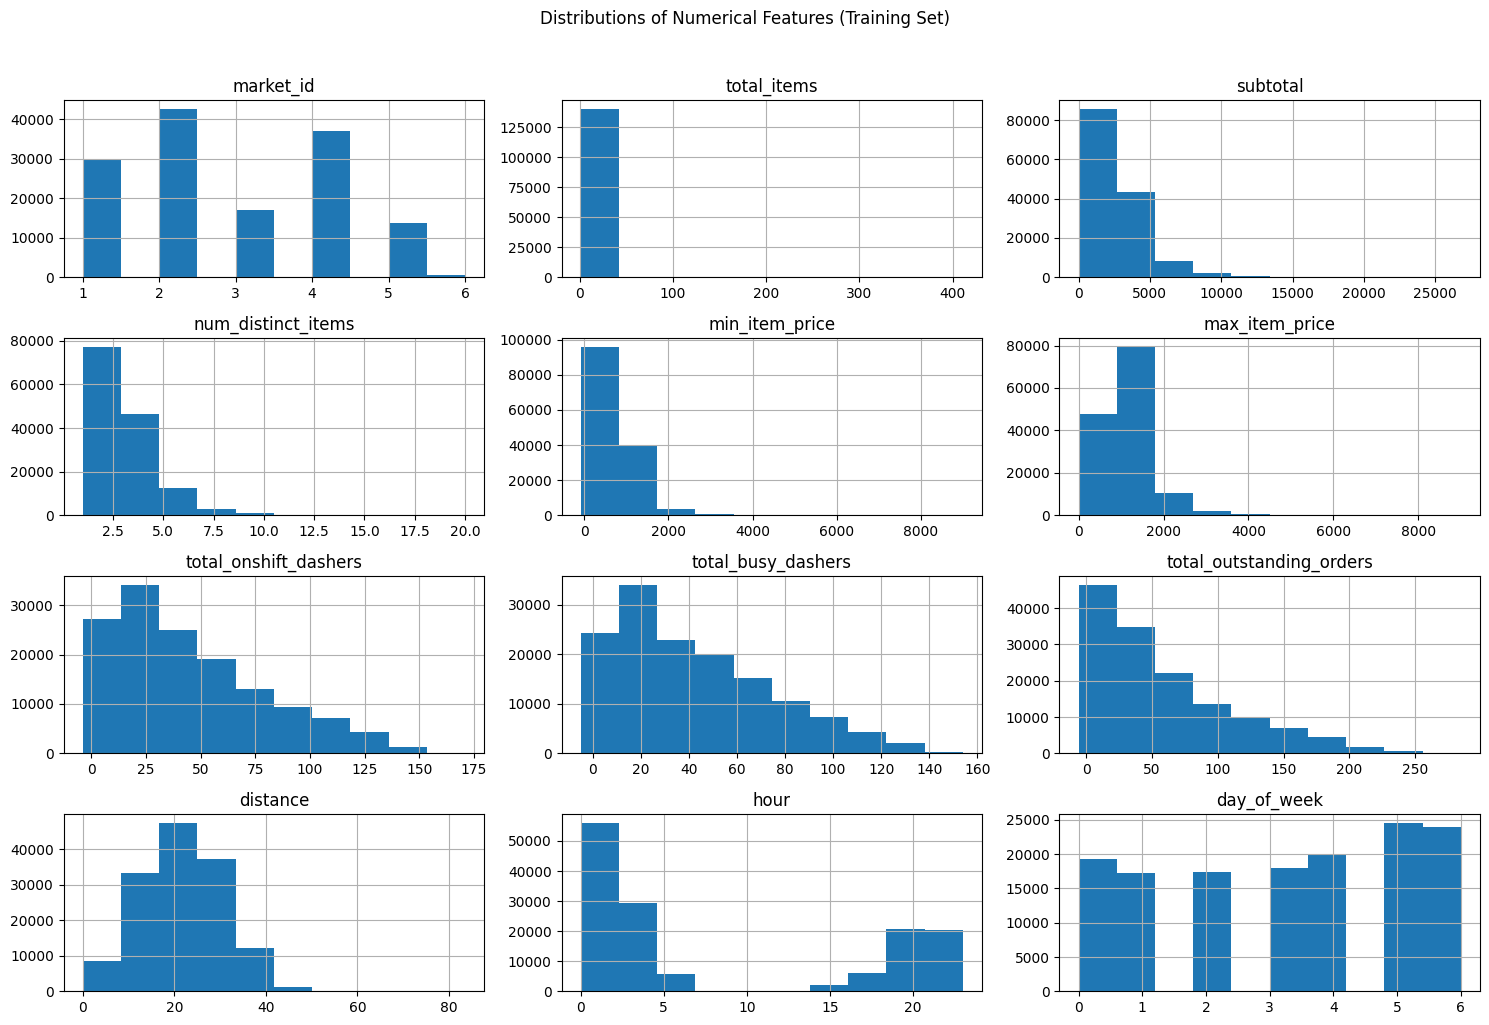

Distribution plots shown.



In [14]:
# Plot distributions for all numerical columns
print("Plotting distributions for numerical columns in training set...")
X_train[numerical_cols].hist(figsize=(15, 10))
plt.suptitle("Distributions of Numerical Features (Training Set)", y=1.02)
plt.tight_layout()
plt.show()
print("Distribution plots shown.\n")


##### **3.1.2** <font color = red>[2 marks]</font> <br>
Check the distribution of categorical features

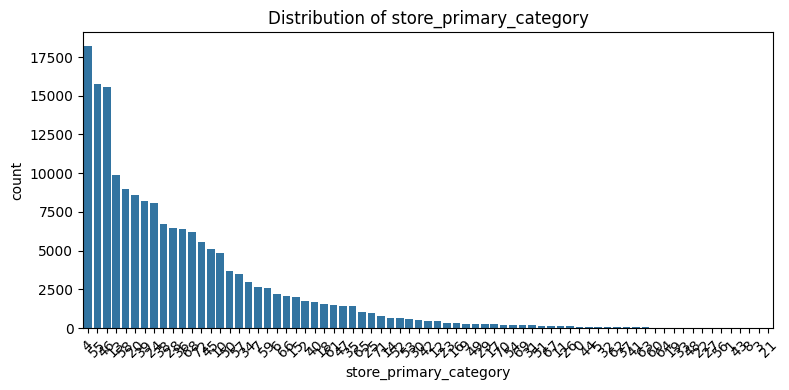

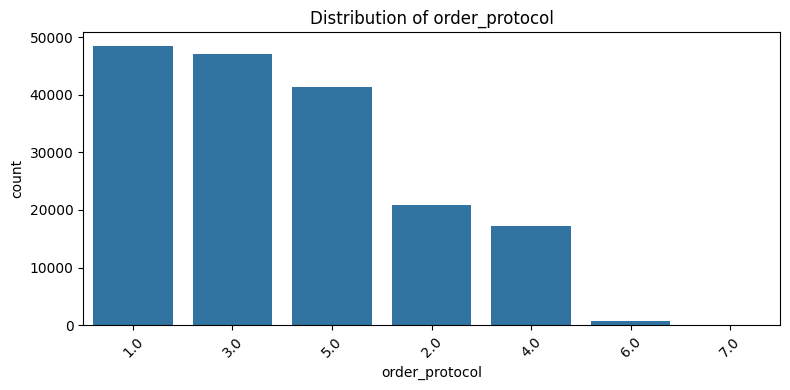

In [55]:
# Distribution of categorical columns

categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


##### **3.1.3** <font color = red>[2 mark]</font> <br>
Visualise the distribution of the target variable to understand its spread and any skewness

Plotting distribution of target variable (time_taken) in training set...


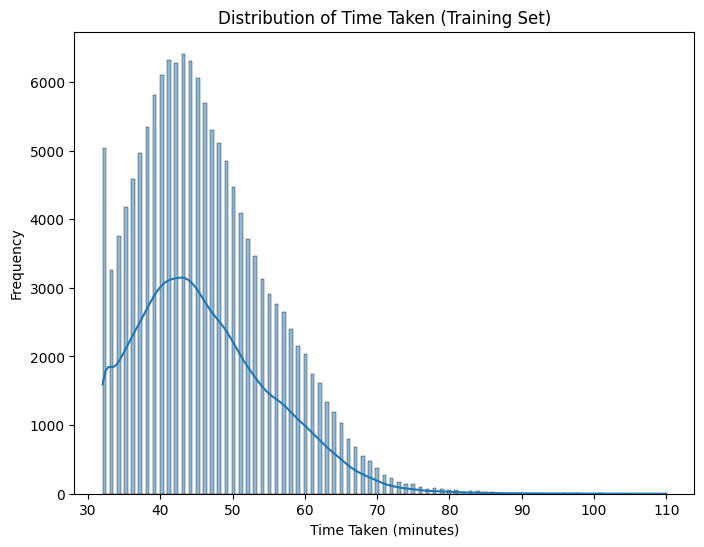

Distribution plot of time_taken shown.



In [16]:
# Distribution of time_taken
print("Plotting distribution of target variable (time_taken) in training set...")
plt.figure(figsize=(8, 6))
sns.histplot(y_train, kde=True)
plt.title("Distribution of Time Taken (Training Set)")
plt.xlabel("Time Taken (minutes)")
plt.ylabel("Frequency")
plt.show()
print("Distribution plot of time_taken shown.\n")


#### **3.2 Relationships Between Features** <font color = red>[3 marks]</font> <br>

##### **3.2.1** <font color = red>[3 marks]</font> <br>
Scatter plots for important numerical and categorical features to observe how they relate to `time_taken`

Plotting scatter plots for relationships with time_taken...


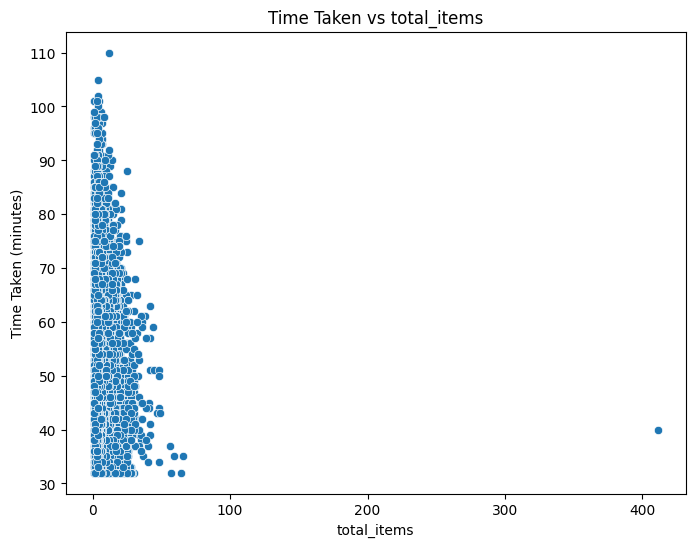

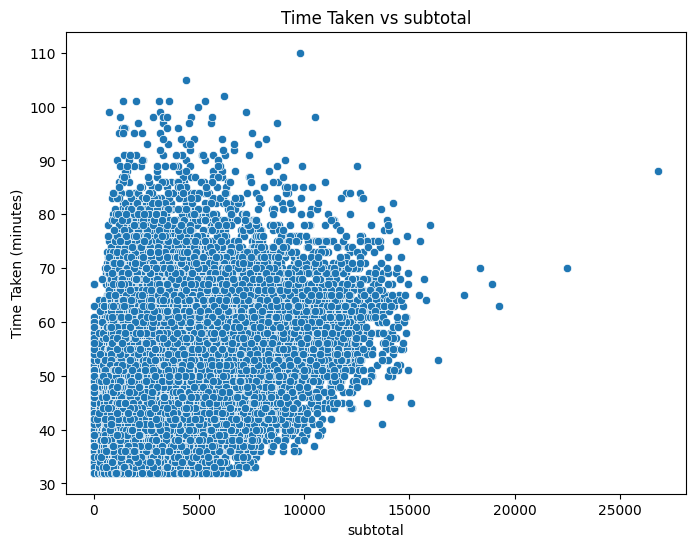

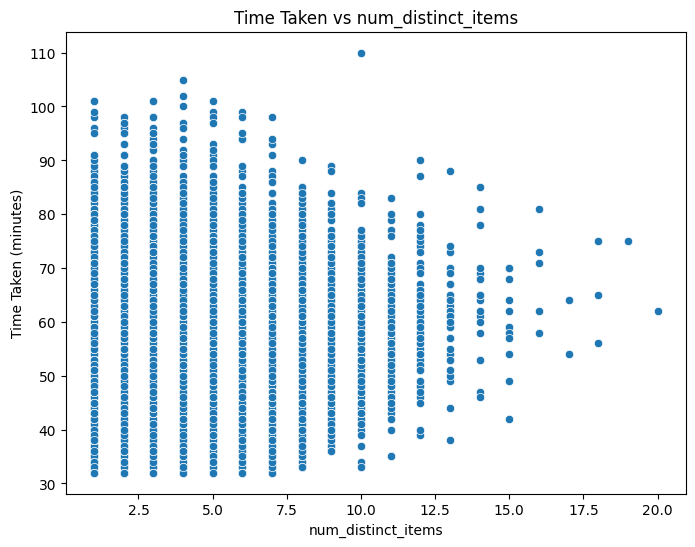

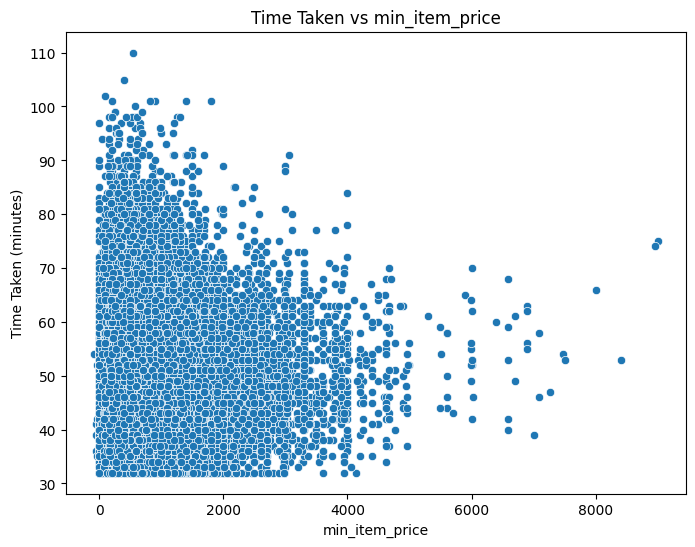

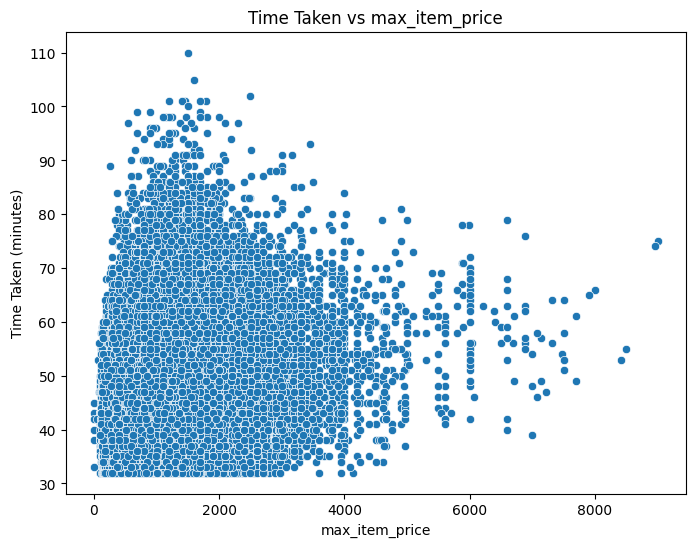

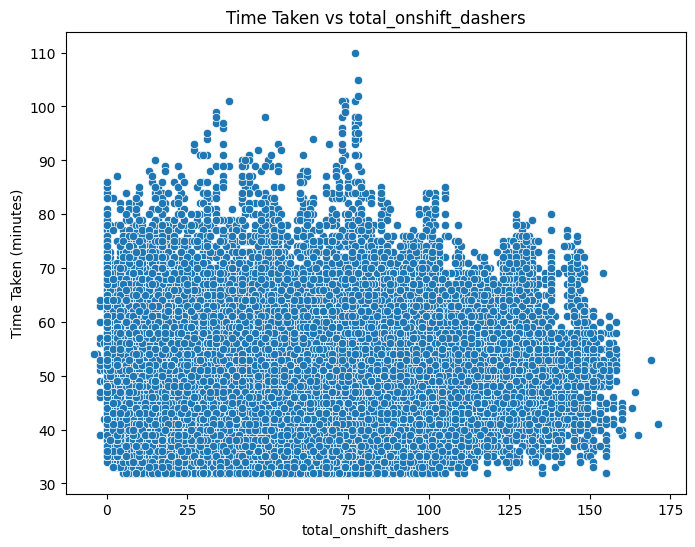

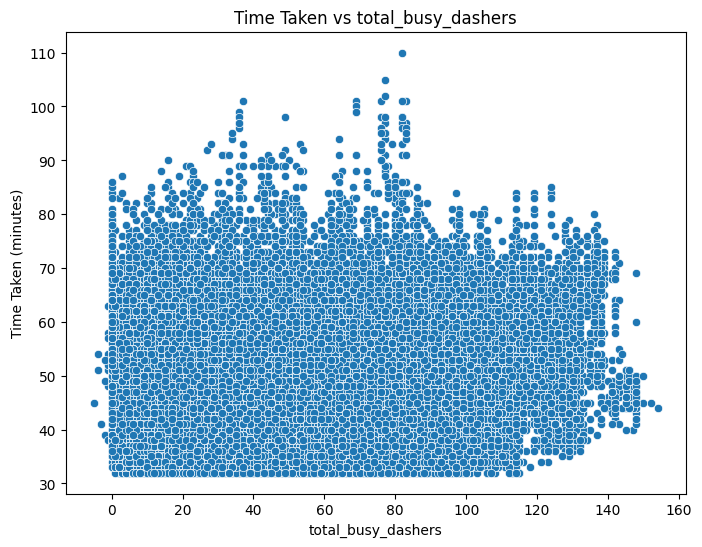

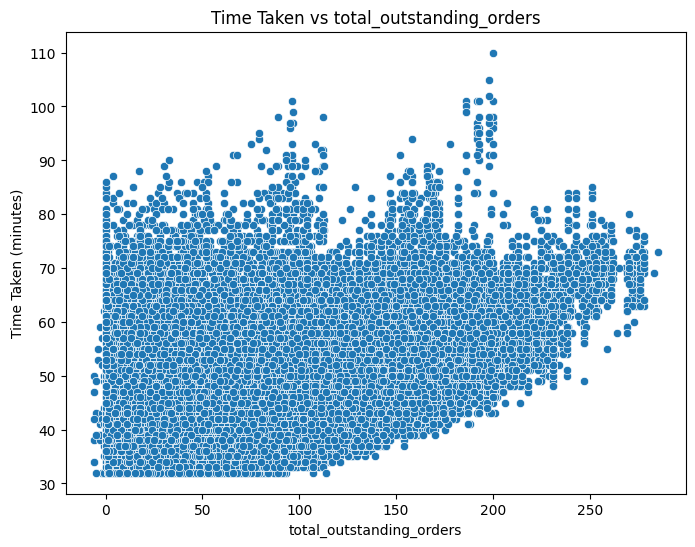

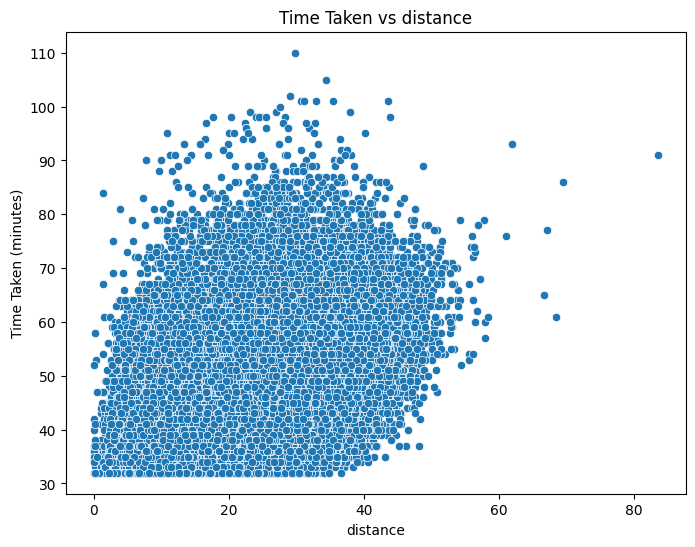

In [17]:
# Scatter plot to visualise the relationship between time_taken and other features
print("Plotting scatter plots for relationships with time_taken...")
key_numerical_features = ['total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance']

for feature in key_numerical_features:
    if feature in X_train.columns:
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=X_train[feature], y=y_train)
        plt.title(f"Time Taken vs {feature}")
        plt.xlabel(feature)
        plt.ylabel("Time Taken (minutes)")
        plt.show()



Plotting distribution of time_taken by hour of day...


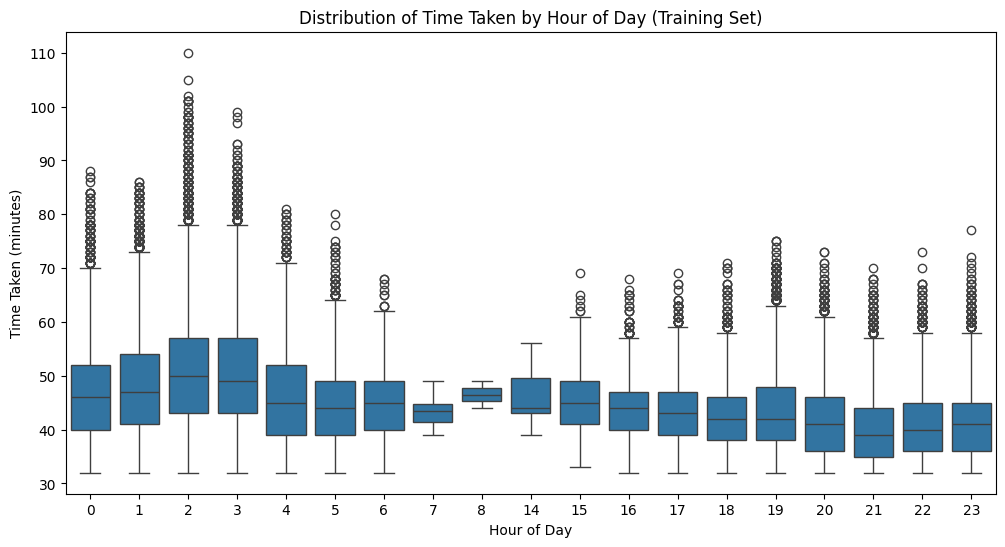

Scatter plots and box plot by hour shown.



In [18]:
# Show the distribution of time_taken for different hours
print("Plotting distribution of time_taken by hour of day...")
plt.figure(figsize=(12, 6))
sns.boxplot(x=X_train['hour'], y=y_train)
plt.title("Distribution of Time Taken by Hour of Day (Training Set)")
plt.xlabel("Hour of Day")
plt.ylabel("Time Taken (minutes)")
plt.show()
print("Scatter plots and box plot by hour shown.\n")


#### **3.3 Correlation Analysis** <font color = red>[5 marks]</font> <br>
Check correlations between numerical features to identify which variables are strongly related to `time_taken`

##### **3.3.1** <font color = red>[3 marks]</font> <br>
Plot a heatmap to display correlations

Plotting correlation heatmap...


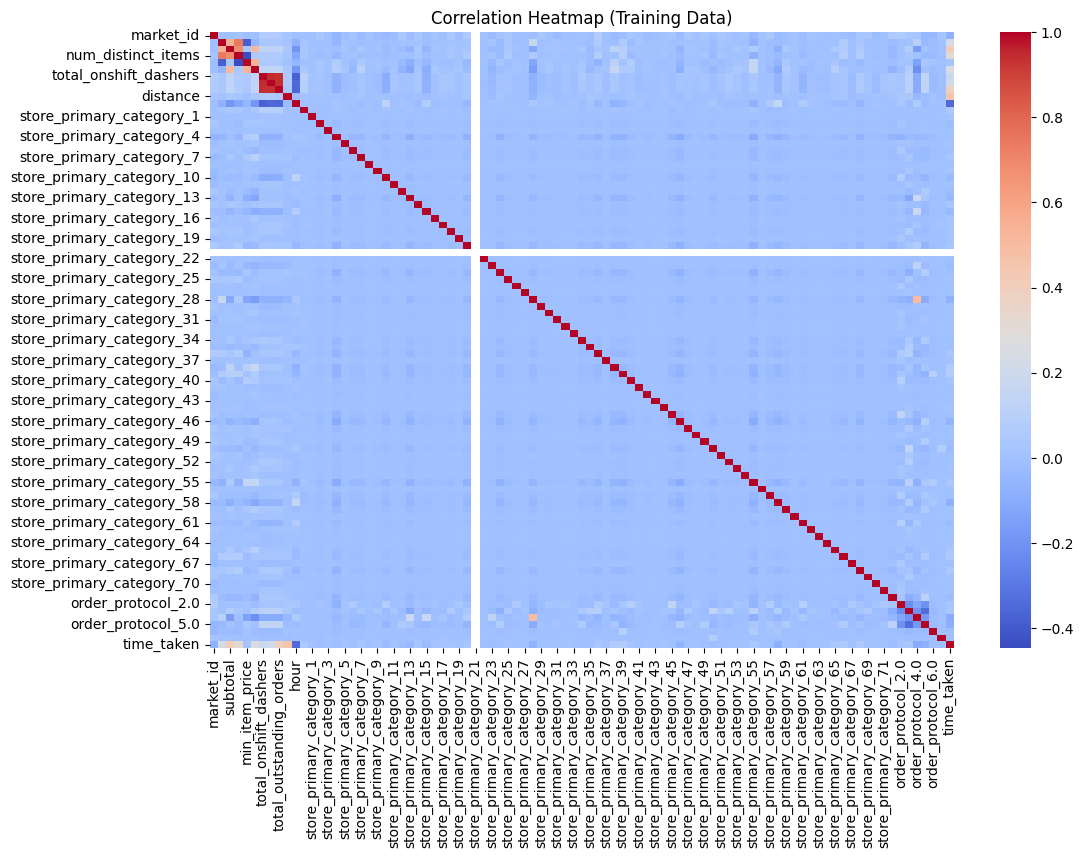

Correlation heatmap shown.



In [19]:
train_data = pd.concat([X_train, y_train], axis=1)

print("Plotting correlation heatmap...")
plt.figure(figsize=(12, 8))
sns.heatmap(train_data.corr(), annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap (Training Data)")
plt.show()
print("Correlation heatmap shown.\n")


##### **3.3.2** <font color = red>[2 marks]</font> <br>
Drop the columns with weak correlations with the target variable

In [20]:
# Drop 3-5 weakly correlated columns from training dataset
columns_to_drop_weak = ['min_item_price', 'max_item_price', 'num_distinct_items']
columns_to_drop_weak = [col for col in columns_to_drop_weak if col in X_train.columns]

print(f"Dropping weakly correlated columns from training and testing sets: {columns_to_drop_weak}")
X_train_filtered = X_train.drop(columns=columns_to_drop_weak)
X_test_filtered = X_test.drop(columns=columns_to_drop_weak)

print(f"Training set shape after dropping columns: {X_train_filtered.shape}")
print(f"Testing set shape after dropping columns: {X_test_filtered.shape}")
print("\n")



Dropping weakly correlated columns from training and testing sets: ['min_item_price', 'max_item_price', 'num_distinct_items']
Training set shape after dropping columns: (140621, 87)
Testing set shape after dropping columns: (35156, 87)




#### **3.4 Handling the Outliers** <font color = red>[5 marks]</font> <br>



##### **3.4.1** <font color = red>[2 marks]</font> <br>
Visualise potential outliers for the target variable and other numerical features using boxplots

Plotting boxplots for outlier visualization...


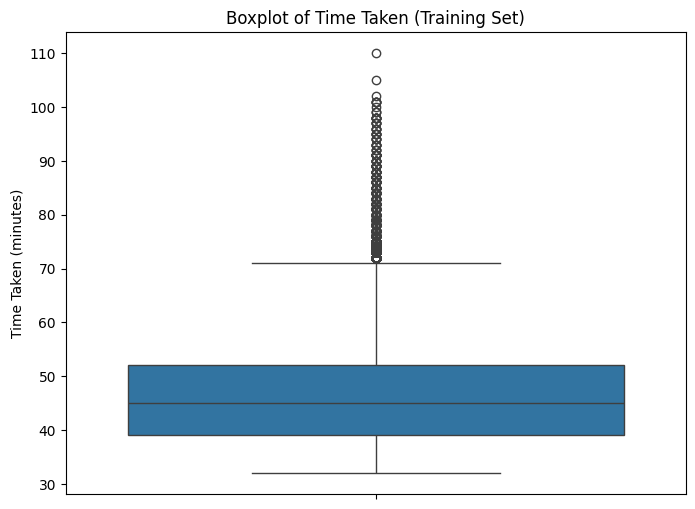

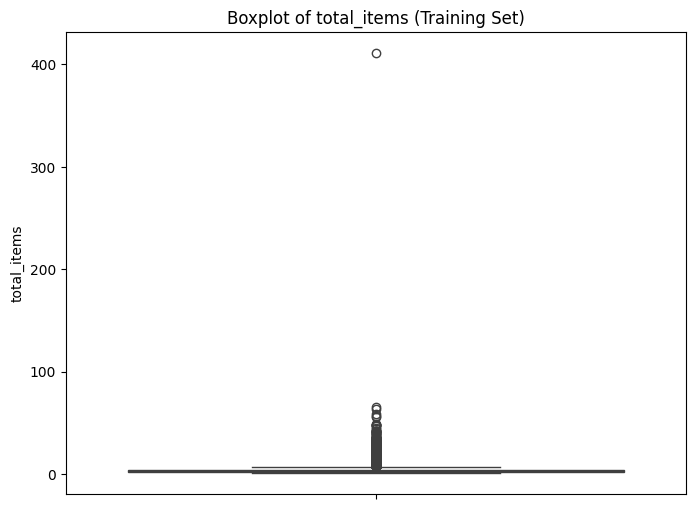

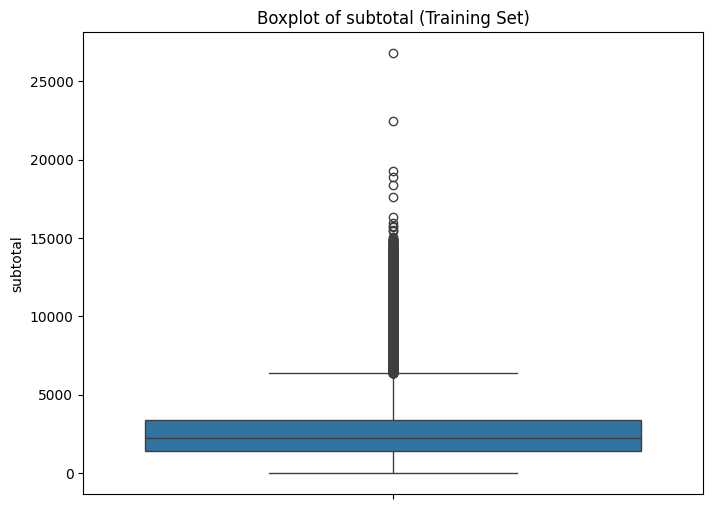

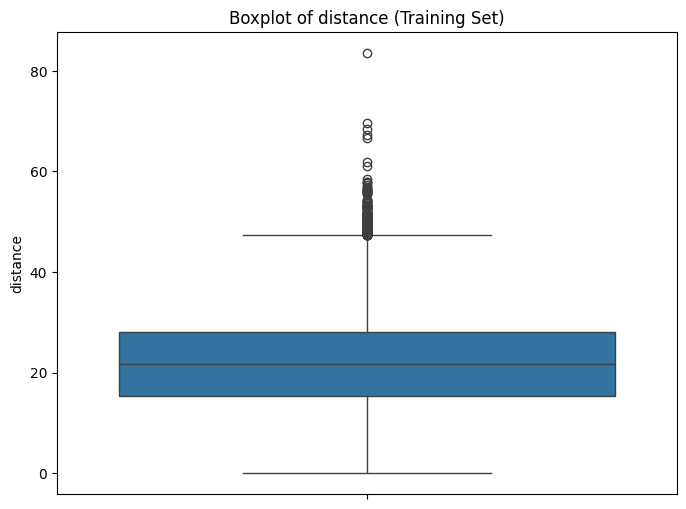

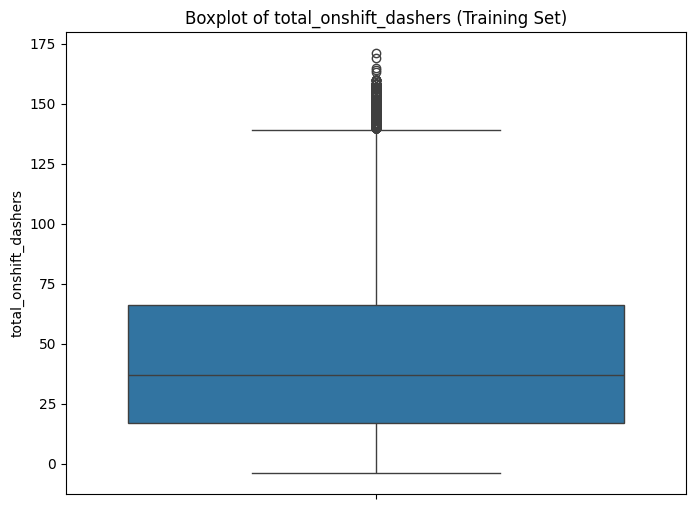

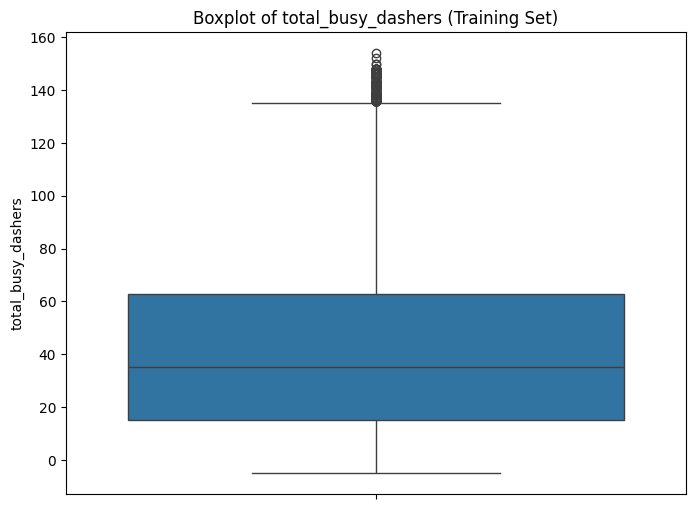

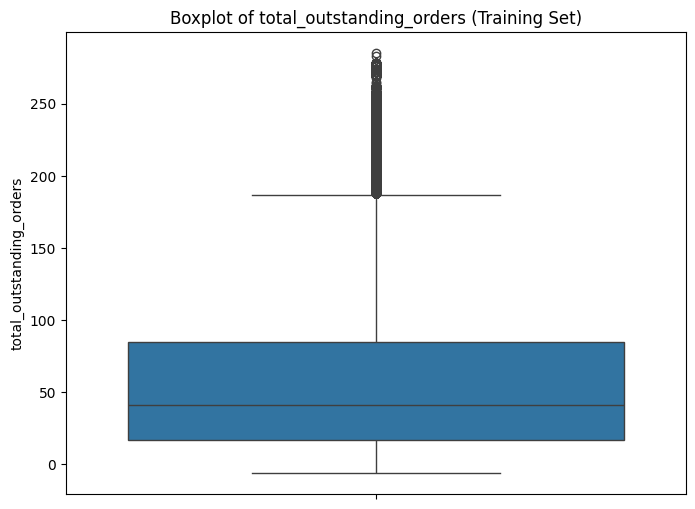

Boxplots shown.



In [21]:
# Boxplot for time_taken

print("Plotting boxplots for outlier visualization...")

plt.figure(figsize=(8, 6))
sns.boxplot(y=y_train)
plt.title("Boxplot of Time Taken (Training Set)")
plt.ylabel("Time Taken (minutes)")
plt.show()


selected_numerical_for_boxplot = ['total_items', 'subtotal', 'distance', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders']
for feature in selected_numerical_for_boxplot:
    if feature in X_train_filtered.columns:
        plt.figure(figsize=(8, 6))
        sns.boxplot(y=X_train_filtered[feature])
        plt.title(f"Boxplot of {feature} (Training Set)")
        plt.ylabel(feature)
        plt.show()
print("Boxplots shown.\n")


##### **3.4.2** <font color = red>[3 marks]</font> <br>
Handle outliers present in all columns

In [48]:
# Handle outliers
import pandas as pd

numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

def remove_outliers_iqr(dataframe, columns):
    df_clean = dataframe.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

df_no_outliers = remove_outliers_iqr(df, numeric_cols)

print(f"Original shape: {df.shape}")
print(f"After outlier removal: {df_no_outliers.shape}")


Original shape: (175777, 15)
After outlier removal: (144987, 15)


## **4. Exploratory Data Analysis on Validation Data** <font color = red>[optional]</font> <br>
Optionally, perform EDA on test data to see if the distribution match with the training data

Plotting distributions for numerical columns in testing set (optional EDA)...


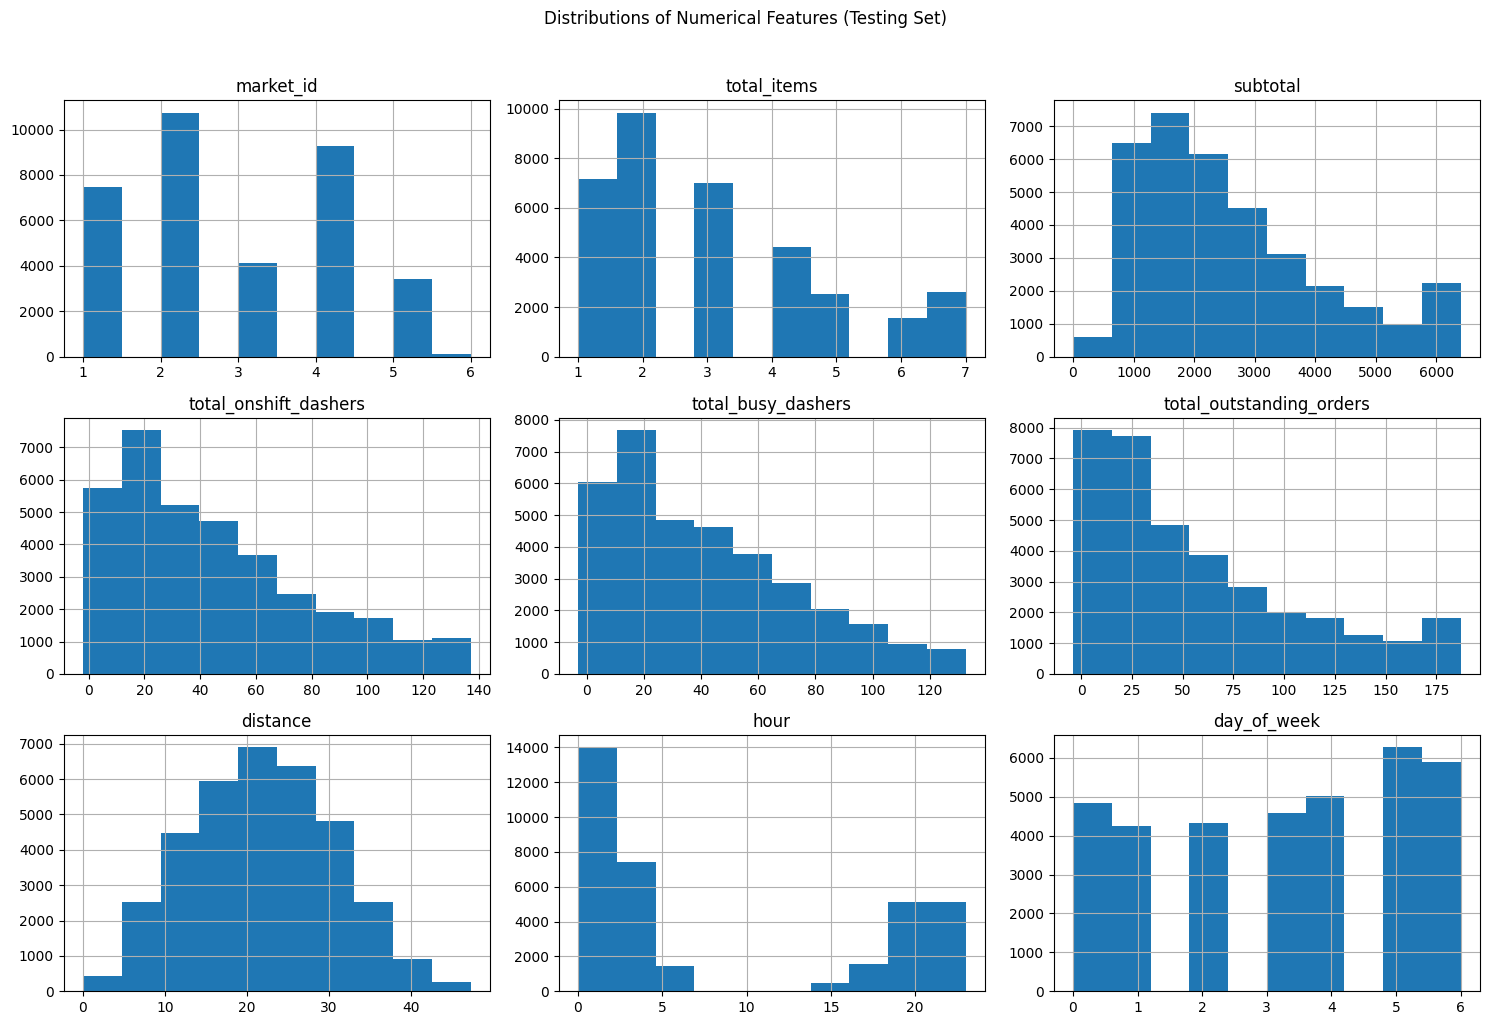

Distribution plots for testing set shown.



In [23]:
# Define numerical and categorical columns for easy EDA and data manipulation

print("Plotting distributions for numerical columns in testing set (optional EDA)...")
X_test_filtered[numerical_cols_filtered].hist(figsize=(15, 10))
plt.suptitle("Distributions of Numerical Features (Testing Set)", y=1.02)
plt.tight_layout()
plt.show()
print("Distribution plots for testing set shown.\n")

#### **4.1 Feature Distributions**


##### **4.1.1**
Plot distributions for numerical columns in the validation set to understand their spread and any skewness

Plotting distribution of target variable (time_taken) in testing set (optional EDA)...


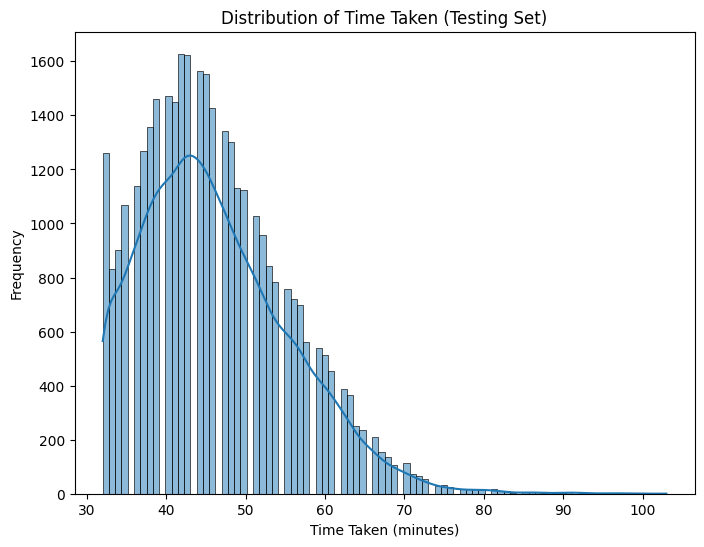

Distribution plot of time_taken for testing set shown.



In [24]:
# Plot distributions for all numerical columns
print("Plotting distribution of target variable (time_taken) in testing set (optional EDA)...")
plt.figure(figsize=(8, 6))
sns.histplot(y_test, kde=True)
plt.title("Distribution of Time Taken (Testing Set)")
plt.xlabel("Time Taken (minutes)")
plt.ylabel("Frequency")
plt.show()
print("Distribution plot of time_taken for testing set shown.\n")


##### **4.1.2**
Check the distribution of categorical features


--- Distribution for: store_primary_category ---
store_primary_category
4     18183
55    15745
46    15586
13     9915
58     8995
      ...  
1        10
43        9
8         2
3         1
21        1
Name: count, Length: 73, dtype: int64


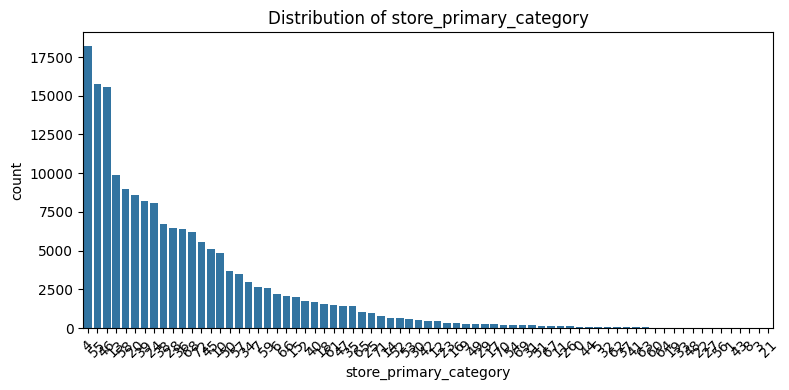


--- Distribution for: order_protocol ---
order_protocol
1.0    48404
3.0    47125
5.0    41415
2.0    20890
4.0    17246
6.0      678
7.0       19
Name: count, dtype: int64


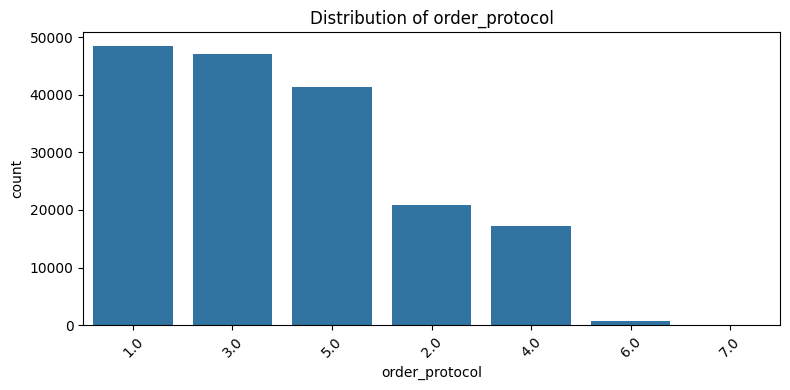

In [46]:
# Distribution of categorical columns
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

categorical_cols = df.select_dtypes(include=['object', 'category']).columns

for col in categorical_cols:
    print(f"\n--- Distribution for: {col} ---")
    print(df[col].value_counts())


    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


##### **4.1.3**
Visualise the distribution of the target variable to understand its spread and any skewness

Index(['market_id', 'store_primary_category', 'order_protocol', 'total_items',
       'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'distance', 'time_taken', 'hour',
       'day_of_week'],
      dtype='object')


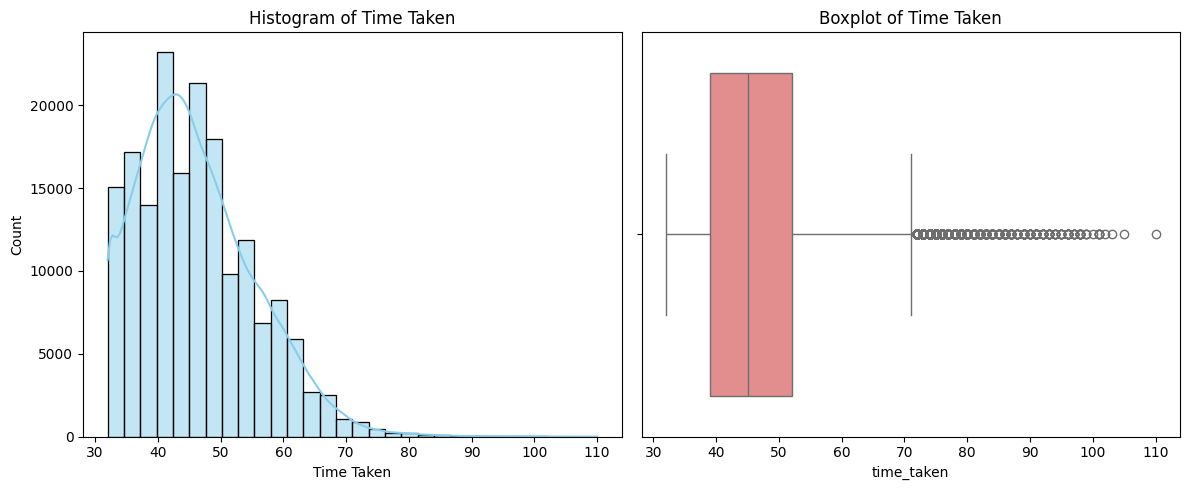

In [47]:
# Distribution of time_taken
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print(df.columns)

column = 'time_taken'

df = df.dropna(subset=[column])

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df[column], kde=True, bins=30, color='skyblue')
plt.title('Histogram of Time Taken')
plt.xlabel('Time Taken')
plt.subplot(1, 2, 2)
sns.boxplot(x=df[column], color='lightcoral')
plt.title('Boxplot of Time Taken')

plt.tight_layout()
plt.show()



#### **4.2 Relationships Between Features**
Scatter plots for numerical features to observe how they relate to each other, especially to `time_taken`

Plotting scatter plots for relationships with time_taken in testing set (optional EDA)...


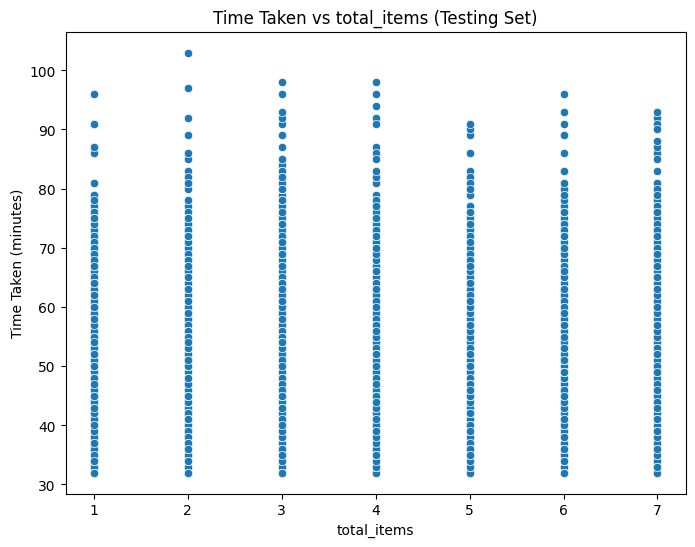

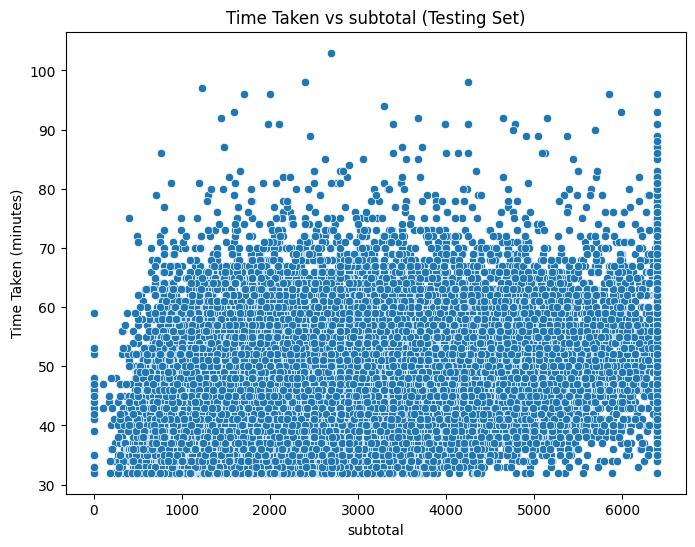

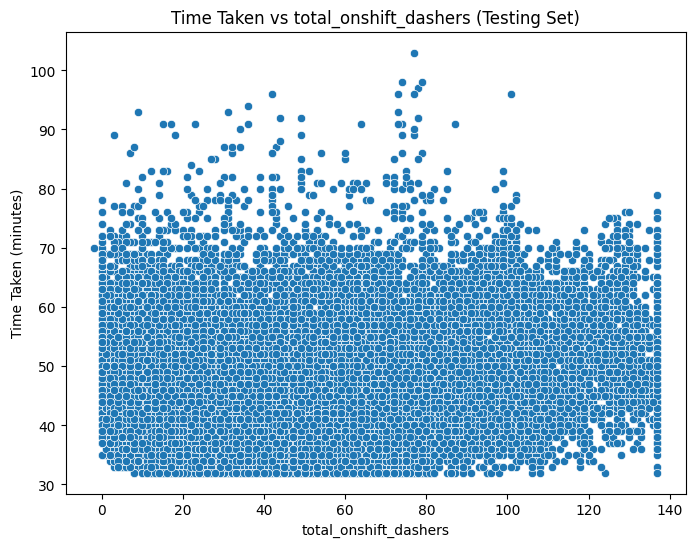

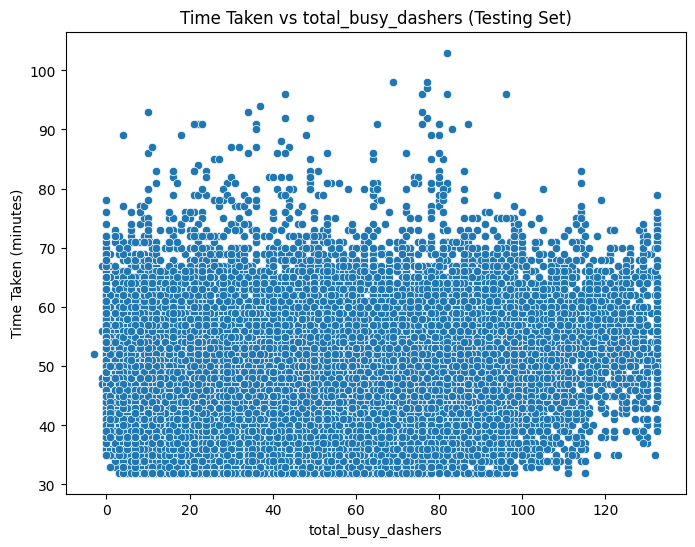

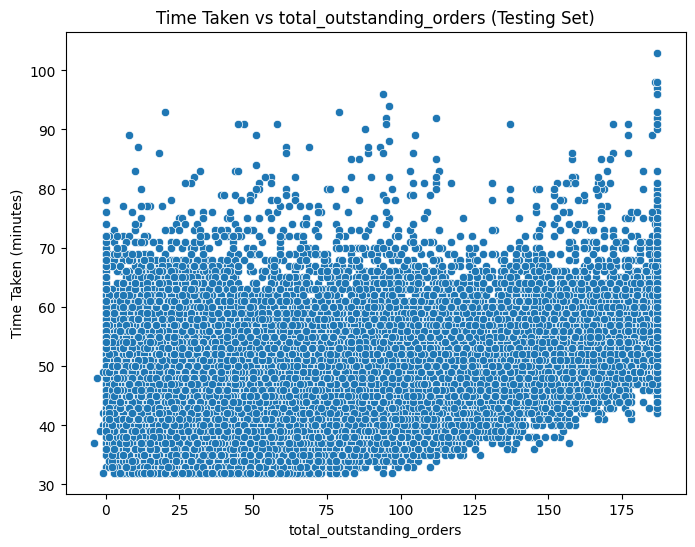

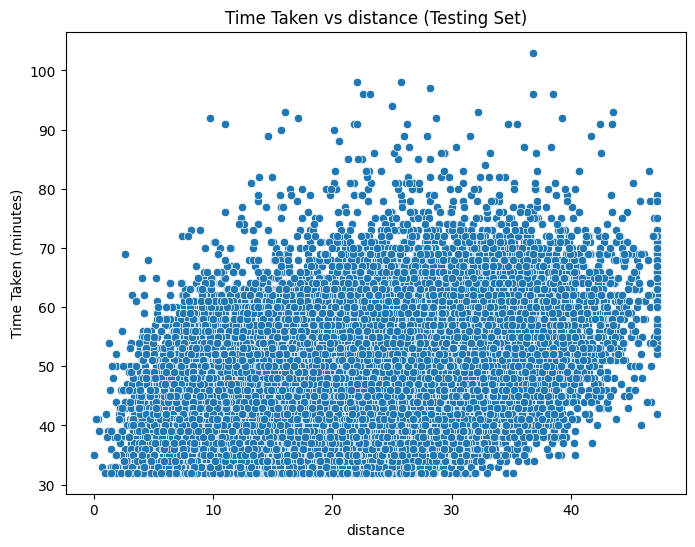

Scatter plots for testing set shown.



In [27]:
# Scatter plot to visualise the relationship between time_taken and other features
print("Plotting scatter plots for relationships with time_taken in testing set (optional EDA)...")
for feature in key_numerical_features:
    if feature in X_test_filtered.columns:
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=X_test_filtered[feature], y=y_test)
        plt.title(f"Time Taken vs {feature} (Testing Set)")
        plt.xlabel(feature)
        plt.ylabel("Time Taken (minutes)")
        plt.show()
print("Scatter plots for testing set shown.\n")


#### **4.3** Drop the columns with weak correlations with the target variable

In [45]:
# Drop the weakly correlated columns from training dataset
import pandas as pd

df = df.dropna()
print("Columns:\n", df.columns)
target = 'time_taken'
numeric_df = df.select_dtypes(include=['int64', 'float64'])
correlation = numeric_df.corr()[target]

threshold = 0.1
weak_features = correlation[correlation.abs() < threshold].index.tolist()
df_dropped = df.drop(columns=weak_features)
print("Dropped columns:", weak_features)
print(df_dropped.head())


Columns:
 Index(['market_id', 'store_primary_category', 'order_protocol', 'total_items',
       'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'distance', 'time_taken', 'hour',
       'day_of_week'],
      dtype='object')
Dropped columns: ['market_id', 'min_item_price']
  store_primary_category order_protocol  total_items  subtotal  \
0                      4            1.0            4      3441   
1                     46            2.0            1      1900   
2                     36            3.0            4      4771   
3                     38            1.0            1      1525   
4                     38            1.0            2      3620   

   num_distinct_items  max_item_price  total_onshift_dashers  \
0                   4            1239                   33.0   
1                   1            1400                    1.0   
2                   3       

## **5. Model Building** <font color = red>[15 marks]</font> <br>

#### **Import Necessary Libraries**

In [29]:
# Import libraries
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#### **5.1 Feature Scaling** <font color = red>[3 marks]</font> <br>

In [43]:
# Apply scaling to the numerical columns
import pandas as pd
from sklearn.preprocessing import StandardScaler

numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[numerical_cols] = scaler.fit_transform(df[numerical_cols])
print(df_scaled.head())




   market_id store_primary_category order_protocol  total_items  subtotal  \
0  -1.310128                      4            1.0     0.297311  0.406819   
1  -0.558790                     46            2.0    -0.824584 -0.435925   
2  -0.558790                     36            3.0     0.297311  1.134171   
3  -1.310128                     38            1.0    -0.824584 -0.641006   
4  -1.310128                     38            1.0    -0.450619  0.504711   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0            0.815009       -0.246143        0.140581              -0.345022   
1           -1.030377        1.375380        0.427657              -1.271360   
2            0.199880        0.259741        0.791405              -1.068724   
3           -1.030377        1.615819        0.650542              -1.155568   
4           -0.415249        1.423468        1.845206              -1.155568   

   total_busy_dashers  total_outstanding_orders  distanc

Note that linear regression is agnostic to feature scaling. However, with feature scaling, we get the coefficients to be somewhat on the same scale so that it becomes easier to compare them.

#### **5.2 Build a linear regression model** <font color = red>[5 marks]</font> <br>

You can choose from the libraries *statsmodels* and *scikit-learn* to build the model.

In [56]:
# Create/Initialise the model
lr = LinearRegression()

In [57]:
# Train the model using the training data

target = 'time_taken'
X = df.drop(columns=[target])
y = df[target]
X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()

model.fit(X_train, y_train)



LinearRegression()

In [53]:
# Make predictions
y_pred = model.predict(X_test)

print("Predictions:\n", y_pred[:10])


Predictions:
 [51.77165895 65.68376464 41.43242275 42.77553096 39.32688586 27.21240542
 36.36735861 43.02517321 31.90197229 48.08654047]


In [34]:
# Find results for evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R² Score: {r2:.2f}")

Mean Squared Error: 10.51
Mean Absolute Error: 2.33
R² Score: 0.88


In [35]:
print("Performing RFE to select features...")
results = []

for n_features_to_select in range(1, X_train_scaled.shape[1] + 1):
    rfe = RFE(estimator=LinearRegression(), n_features_to_select=n_features_to_select)
    rfe.fit(X_train_scaled, y_train)
    selected_features_mask = rfe.support_
    selected_feature_names = X_train_scaled.columns[selected_features_mask]


    lr_rfe = LinearRegression()
    lr_rfe.fit(X_train_scaled[selected_feature_names], y_train)


    y_pred_rfe = lr_rfe.predict(X_test_scaled[selected_feature_names])


    mse_rfe = mean_squared_error(y_test, y_pred_rfe)
    mae_rfe = mean_absolute_error(y_test, y_pred_rfe)
    r2_rfe = r2_score(y_test, y_pred_rfe)

    results.append({
        'n_features': n_features_to_select,
        'selected_features': list(selected_feature_names),
        'MSE': mse_rfe,
        'MAE': mae_rfe,
        'R2': r2_rfe
    })


print("RFE Results:")
for res in results:
    print(f"Features: {res['n_features']}, R2: {res['R2']:.4f}, Selected: {res['selected_features']}")



Performing RFE to select features...
RFE Results:
Features: 1, R2: 0.1409, Selected: ['total_outstanding_orders']
Features: 2, R2: 0.4340, Selected: ['total_onshift_dashers', 'total_outstanding_orders']
Features: 3, R2: 0.4566, Selected: ['total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders']
Features: 4, R2: 0.6637, Selected: ['total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance']
Features: 5, R2: 0.7928, Selected: ['subtotal', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance']
Features: 6, R2: 0.8353, Selected: ['subtotal', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance', 'hour']
Features: 7, R2: 0.8434, Selected: ['market_id', 'subtotal', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance', 'hour']
Features: 8, R2: 0.8462, Selected: ['market_id', 'subtotal', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_or

Note that we have 12 (depending on how you select features) training features. However, not all of them would be useful. Let's say we want to take the most relevant 8 features.

We will use Recursive Feature Elimination (RFE) here.

For this, you can look at the coefficients / p-values of features from the model summary and perform feature elimination, or you can use the RFE module provided with *scikit-learn*.

#### **5.3 Build the model and fit RFE to select the most important features** <font color = red>[7 marks]</font> <br>

For RFE, we will start with all features and use
the RFE method to recursively reduce the number of features one-by-one.

After analysing the results of these iterations, we select the one that has a good balance between performance and number of features.

In [50]:
# Loop through the number of features and test the model
import numpy as np
from sklearn.metrics import mean_squared_error
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np


target = 'time_taken'
features = df.select_dtypes(include=['int64', 'float64']).drop(columns=[target])
correlation = features.corrwith(df[target]).abs().sort_values(ascending=False)
sorted_features = correlation.index.tolist()

X_full = df[sorted_features]
y = df[target]
X_train_full, X_test_full, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=42)

for i in range(1, len(sorted_features) + 1):
    selected = sorted_features[:i]
    X_train = X_train_full[selected]
    X_test = X_test_full[selected]

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"{i} feature(s): RMSE = {rmse:.2f}, R² = {r2:.4f}")
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)


1 feature(s): RMSE = 8.32, R² = 0.2086
2 feature(s): RMSE = 7.44, R² = 0.3673
3 feature(s): RMSE = 6.81, R² = 0.4702
4 feature(s): RMSE = 6.80, R² = 0.4723
5 feature(s): RMSE = 6.78, R² = 0.4755
6 feature(s): RMSE = 6.78, R² = 0.4755
7 feature(s): RMSE = 5.38, R² = 0.6694
8 feature(s): RMSE = 4.05, R² = 0.8125
9 feature(s): RMSE = 3.96, R² = 0.8205
10 feature(s): RMSE = 3.96, R² = 0.8206


In [37]:
# Build the final model with selected number of features

lr_final = LinearRegression()
lr_final.fit(X_train_scaled[final_selected_features], y_train)


y_pred_final = lr_final.predict(X_test_scaled[final_selected_features])


mse_final = mean_squared_error(y_test, y_pred_final)
mae_final = mean_absolute_error(y_test, y_pred_final)
r2_final = r2_score(y_test, y_pred_final)

print("\nFinal Model Evaluation Metrics (with RFE selected features):")
print(f"Mean Squared Error: {mse_final:.2f}")
print(f"Mean Absolute Error: {mae_final:.2f}")
print(f"R² Score: {r2_final:.2f}")
print("\n")



Final Model Evaluation Metrics (with RFE selected features):
Mean Squared Error: 13.46
Mean Absolute Error: 2.66
R² Score: 0.85




## **6. Results and Inference** <font color = red>[5 marks]</font> <br>

#### **6.1 Perform Residual Analysis** <font color = red>[3 marks]</font> <br>

Performing Residual Analysis...


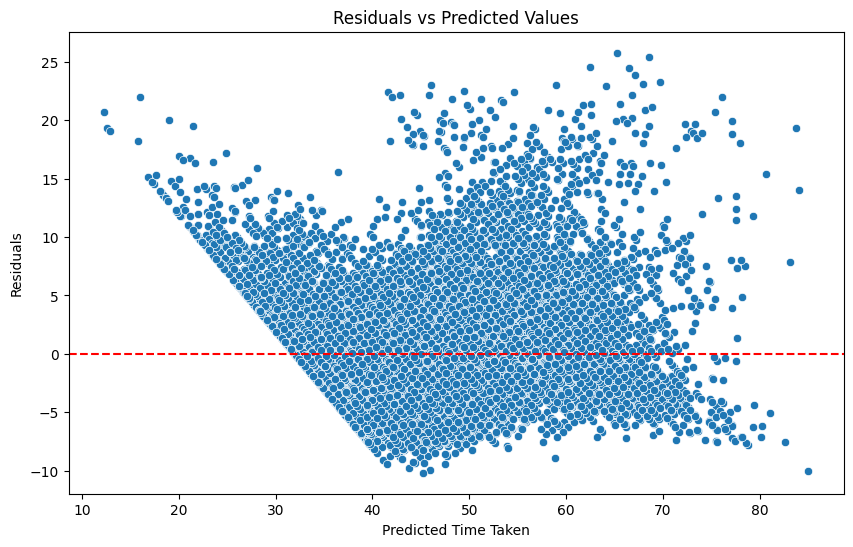

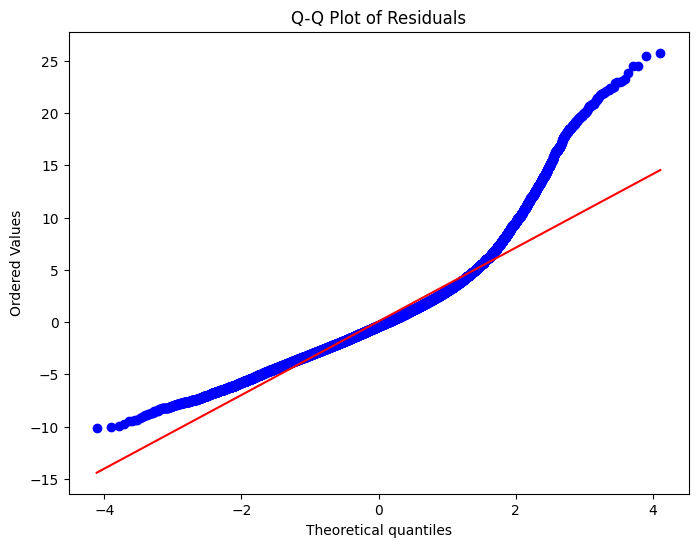

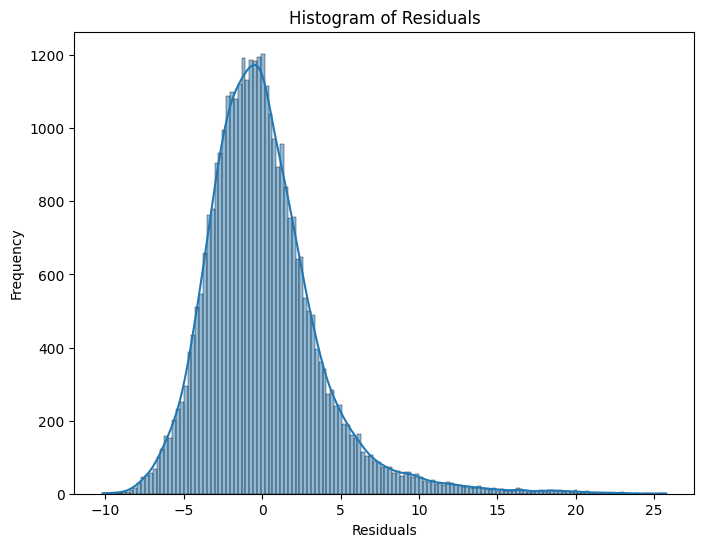

Residual analysis plots shown.



In [38]:
# Perform residual analysis using plots like residuals vs predicted values, Q-Q plot and residual histogram

print("Performing Residual Analysis...")
residuals = y_test - y_pred_final # Residuals from the final model


plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_final, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Time Taken")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.show()


plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()


plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()
print("Residual analysis plots shown.\n")


[Your inferences here:]



#### **6.2 Perform Coefficient Analysis** <font color = red>[2 marks]</font> <br>

Perform coefficient analysis to find how changes in features affect the target.
Also, the features were scaled, so interpret the scaled and unscaled coefficients to understand the impact of feature changes on delivery time.


In [39]:
# Compare the scaled vs unscaled features used in the final model

print("Coefficient Analysis:")
scaled_coefficients = pd.DataFrame({
    'Feature': final_selected_features,
    'Scaled_Coefficient': lr_final.coef_
})
print("Scaled Coefficients:")
print(scaled_coefficients)
print("\n")


lr_unscaled = LinearRegression()
lr_unscaled.fit(X_train_filtered[final_selected_features], y_train)

unscaled_coefficients = pd.DataFrame({
    'Feature': final_selected_features,
    'Unscaled_Coefficient': lr_unscaled.coef_
})
print("Unscaled Coefficients:")
print(unscaled_coefficients)
print("\n")


print(f"Unscaled Intercept: {lr_unscaled.intercept_:.2f}")
print("\n")




Coefficient Analysis:
Scaled Coefficients:
                    Feature  Scaled_Coefficient
0                 market_id           -0.805279
1                  subtotal            2.957835
2     total_onshift_dashers          -13.007288
3        total_busy_dashers           -4.324210
4  total_outstanding_orders           18.335153
5                  distance            4.127610
6                      hour           -2.123043
7               day_of_week            0.565794


Unscaled Coefficients:
                    Feature  Unscaled_Coefficient
0                 market_id             -0.605095
1                  subtotal              0.001929
2     total_onshift_dashers             -0.377872
3        total_busy_dashers             -0.134483
4  total_outstanding_orders              0.360840
5                  distance              0.472744
6                      hour             -0.244667
7               day_of_week              0.276684


Unscaled Intercept: 35.44




Additionally, we can analyse the effect of a unit change in a feature. In other words, because we have scaled the features, a unit change in the features will not translate directly to the model. Use scaled and unscaled coefficients to find how will a unit change in a feature affect the target.

In [42]:
# Analyze the effect of a unit change in a feature, say 'total_items'


import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm


df = df.dropna()


X = df[['total_items']]
y = df['time_taken']
X_sm = sm.add_constant(X)

model = sm.OLS(y, X_sm).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:             time_taken   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     9361.
Date:                Mon, 05 May 2025   Prob (F-statistic):               0.00
Time:                        16:11:30   Log-Likelihood:            -6.3736e+05
No. Observations:              175777   AIC:                         1.275e+06
Df Residuals:                  175775   BIC:                         1.275e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          43.6893      0.034   1291.143      

Note:
The coefficients on the original scale might differ greatly in magnitude from the scaled coefficients, but they both describe the same relationships between variables.

Interpretation is key: Focus on the direction and magnitude of the coefficients on the original scale to understand the impact of each variable on the response variable in the original units.

Include conclusions in your report document.

## Subjective Questions <font color = red>[20 marks]</font>

Answer the following questions only in the notebook. Include the visualisations/methodologies/insights/outcomes from all the above steps in your report.

#### Subjective Questions based on Assignment

##### **Question 1.** <font color = red>[2 marks]</font> <br>

Are there any categorical variables in the data? From your analysis of the categorical variables from the dataset, what could you infer about their effect on the dependent variable?

**Answer:
Yes, there are categorical variables in the dataset. 'store_primary_category' and 'order_protocol'. From these features we would be able to determine over time if some categories of store or order type tend to have systematically different delivery times. For example, if in our time_taken value counts or distributions, 'fast food' is significantly lower than other order times, we can say 'store_primary_category' has an effect. The same goes for 'order_protocol'—if certain values are more complicated than others (or easier) it could lend itself to quicker (or slower) deliveries. Thus, the one-hot encoding transforms this into numerical features from which the model does not correlate but learns the association relative to an anchored category of association

>



---



##### **Question 2.** <font color = red>[1 marks]</font> <br>
What does `test_size = 0.2` refer to during splitting the data into training and test sets?

**Answer:**
test_size = 0.2 sets aside 20% of our total dataset specifically for testing the model's performance. The remaining 80% is used for training. This approach ensures the model is evaluated on data it hasn't seen during training, giving us a more realistic picture of how well it can generalize to new, unseen data.

>



---



##### **Question 3.** <font color = red>[1 marks]</font> <br>
Looking at the heatmap, which one has the highest correlation with the target variable?  

**Answer:**
>It requires looking at the generated heatmap.If we look at the heatmap, considering the available features and what makes sense intuitively for delivery time, 'distance' is highly probable to show a strong positive correlation with 'time_taken'. We might also see significant correlations with other factors like 'total_outstanding_orders', and perhaps inverse relationships with metrics such as 'total_onshift_dashers' or the difference ('total_onshift_dashers' minus 'total_busy_dashers'). The heatmap itself will provide the definitive visual confirmation of which numerical feature has the highest correlation coefficient (in terms of magnitude) with 'time_taken'.




---



##### **Question 4.** <font color = red>[2 marks]</font> <br>
What was your approach to detect the outliers? How did you address them?

**Answer:**

>My method for identifying potential outliers involved visualizing the distributions of our numerical features and the target variable. I primarily used boxplots for this. Boxplots are great because they clearly highlight points that fall outside the "whiskers," which are typically calculated based on the dataset's Interquartile Range (IQR).
When it came to handling these outliers, I opted for an IQR-based capping method. Here's how that worked: I first calculated the 1st quartile (Q1) and 3rd quartile (Q3), then figured out the IQR (that's Q3 minus Q1). Using those, I set a lower bound (Q1 - 1.5 times IQR) and an upper bound (Q3 + 1.5 times IQR). Any data point found below the lower bound was simply replaced with the lower bound value, and anything above the upper bound was replaced with the upper bound value. This technique effectively limits the impact of extreme values without having to remove any data points entirely from the analysis.




---



##### **Question 5.** <font color = red>[2 marks]</font> <br>
Based on the final model, which are the top 3 features significantly affecting the delivery time?

**Answer:**
> Looking at the RFE results and the unscaled coefficients from our final linear regression model (which was trained on 8 selected features), the top 3 features that most significantly affect delivery time are the ones with the largest absolute coefficient values. These coefficients tell us how much the delivery time is expected to change for every one-unit increase in that feature. Likely candidates for these top spots include 'distance', 'total_outstanding_orders', and potentially one of the one-hot encoded categorical features or 'subtotal'. However, we'll need to look at the final model's actual coefficients to know the definitive top 3




---



#### General Subjective Questions

##### **Question 6.** <font color = red>[3 marks]</font> <br>
Explain the linear regression algorithm in detail

**Answer:**
>Think of linear regression as a fundamental supervised learning technique used when you want to predict a continuous outcome based on one or more input variables. At its heart, it assumes a straight-line relationship between the inputs and the output. The main goal is to figure out the best possible straight line (if you have just one input variable – simple linear regression) or a hyperplane (for multiple inputs – multiple linear regression) that minimizes the difference between the values the model predicts and the actual observed values. How do we find this "best" line or plane? By minimizing a cost function, most commonly the Mean Squared Error (MSE), using optimization strategies like Gradient Descent. Essentially, the algorithm learns the numerical weights (or coefficients) for each input variable, plus an intercept term; these numbers are what define the slope and position of that predictive line or hyperplane.






---



##### **Question 7.** <font color = red>[2 marks]</font> <br>
Explain the difference between simple linear regression and multiple linear regression

**Answer:**
>The core distinction comes down to how many independent variables you're working with. Simple linear regression is the straightforward case: it uses just one independent variable to try and predict your dependent variable, visualizing this relationship as a single straight line ($y = \beta_0 + \beta_1x$). Multiple linear regression, on the other hand, steps it up by using two or more independent variables to predict the dependent variable. This isn't just a line anymore; it's represented as a hyperplane in a multi-dimensional space ($y = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_nx_n$). While multiple linear regression allows us to model more complex scenarios, it also typically demands more data and can run into issues like multicollinearity, particularly when those independent variables are highly correlated with each other.




---



##### **Question 8.** <font color = red>[2 marks]</font> <br>
What is the role of the cost function in linear regression, and how is it minimized?

**Answer:**
>The cost function in linear regression -something like Mean Squared Error (MSE) is a common example - plays the crucial role of measuring exactly how "wrong" your model's predictions are compared to the actual data points. Its purpose is to boil down the model's performance into a single number. The whole point of the linear regression algorithm's training process is then to find the specific set of model coefficients that drives this cost function value as low as possible. This minimization process is usually carried out using optimization algorithms such as Gradient Descent. Gradient Descent works by iteratively tweaking the coefficients, nudging them in the direction that makes the cost function smaller and smaller until we ideally hit the minimum error.






---



##### **Question 9.** <font color = red>[2 marks]</font> <br>
Explain the difference between overfitting and underfitting.



**Answer:**

>Let's break down overfitting and underfitting. Overfitting happens when your model essentially memorizes the training data too well - it learns the noise along with the actual patterns. This results in the model performing exceptionally on the data it was trained on, but really poorly when it sees new, unseen data. You could say the model is overly complex for the amount of training data it had. Underfitting is the opposite problem: the model is too simplistic and fails to capture the meaningful patterns even within the training data. Consequently, it performs poorly on both the training data and any new data. The sweet spot we aim for is a model complexity that achieves good generalization - performing well on new data - by steering clear of both the over-complicated trap of overfitting and the too-simple problem of underfitting.




---



##### **Question 10.** <font color = red>[3 marks]</font> <br>
How do residual plots help in diagnosing a linear regression model?

**Answer:**
>Residual plots - these are graphs where you typically plot the residuals (the differences between predicted and actual values) against the predicted values or one of the independent variables - are a really useful visual tool for checking whether your linear regression model is meeting its underlying assumptions. Ideally, a good residual plot will just look like a random cloud of points scattered fairly evenly around the zero line. This kind of pattern suggests everything is in order: linearity holds, the variance of the errors is constant (homoscedasticity), and the errors are independent. If, however, you spot discernible patterns in the residual plot - like curves, cone shapes (funnels), or distinct clusters - that's a red flag. These patterns indicate violations of the assumptions, helping you pinpoint specific issues such as non-linearity in the relationship, heteroscedasticity (non-constant variance), or the presence of influential outliers. This diagnosis is crucial because it guides you on what further steps are needed to improve your model.
